# 🧬 Clinical Trial Outcome Predictor

**Author:** Jason Finkle  
**Project:** Healthcare/Biotech ML Classification  

This project predicts whether a clinical trial will successfully complete or terminate early using data from [ClinicalTrials.gov](https://clinicaltrials.gov). By analyzing trial characteristics such as phase, sponsor type, enrollment size, and study design, we build machine learning models to identify factors associated with trial success.

**Business Value:** Clinical trials cost an average of $20-40 million. Early prediction of trial failure could help pharmaceutical companies and research institutions allocate resources more effectively and identify at-risk trials for intervention.

---

## 1. Setup and Configuration

In [31]:
# Core libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
import warnings
from datetime import datetime
from collections import Counter
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_curve, auc,
                             precision_recall_curve, average_precision_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Model Interpretability
import shap

# Survival Analysis
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Set random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Create figures directory
import os
os.makedirs('figures', exist_ok=True)
os.makedirs('data', exist_ok=True)

# Define color palette
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'accent': '#F18F01',
    'success': '#28A745',
    'danger': '#DC3545',
    'dark': '#343A40',
    'purple': '#6F42C1',
    'teal': '#20C997'
}

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("✅ Libraries loaded successfully")
print("   - SHAP for model interpretability")
print("   - Lifelines for survival analysis")

✅ Libraries loaded successfully
   - SHAP for model interpretability
   - Lifelines for survival analysis


## 2. Data Collection from ClinicalTrials.gov API

We'll use the ClinicalTrials.gov API v2 to fetch clinical trials with definitive outcomes:
- **COMPLETED** → Success (Target = 1)
- **TERMINATED** → Failure (Target = 0)

We focus on interventional trials (not observational) with drug, biological, or device interventions.

In [3]:
def fetch_clinical_trials(status, max_studies=5000, page_size=100):
    """
    Fetch clinical trials from ClinicalTrials.gov API v2

    Parameters:
    -----------
    status : str
        Trial status (COMPLETED or TERMINATED)
    max_studies : int
        Maximum number of studies to fetch
    page_size : int
        Number of studies per API request (max 100)

    Returns:
    --------
    list : List of study dictionaries
    """

    base_url = "https://clinicaltrials.gov/api/v2/studies"
    all_studies = []
    page_token = None

    # Fields to request
    fields = [
        "NCTId",
        "BriefTitle",
        "OverallStatus",
        "Phase",
        "StudyType",
        "EnrollmentCount",
        "EnrollmentType",
        "StartDate",
        "PrimaryCompletionDate",
        "CompletionDate",
        "LeadSponsorName",
        "LeadSponsorClass",
        "CollaboratorName",
        "InterventionType",
        "InterventionName",
        "Condition",
        "DesignAllocation",
        "DesignInterventionModel",
        "DesignPrimaryPurpose",
        "DesignMasking",
        "ArmGroupType",
        "LocationCountry",
        "MinimumAge",
        "MaximumAge",
        "Sex",
        "StdAge",
        "IsFDARegulatedDrug",
        "IsFDARegulatedDevice",
        "WhyStopped"
    ]

    print(f"📥 Fetching {status} trials...")

    while len(all_studies) < max_studies:
        params = {
            "format": "json",
            "pageSize": min(page_size, max_studies - len(all_studies)),
            "filter.overallStatus": status,
            "query.term": "AREA[StudyType]INTERVENTIONAL",
            "fields": "|".join(fields),
            "countTotal": "true"
        }

        if page_token:
            params["pageToken"] = page_token

        try:
            response = requests.get(base_url, params=params, timeout=30)
            response.raise_for_status()
            data = response.json()

            studies = data.get("studies", [])
            if not studies:
                break

            all_studies.extend(studies)

            # Get next page token
            page_token = data.get("nextPageToken")
            if not page_token:
                break

            # Progress update
            if len(all_studies) % 500 == 0:
                print(f"   Retrieved {len(all_studies):,} studies...")

            # Rate limiting (be respectful to the API)
            time.sleep(0.5)

        except requests.exceptions.RequestException as e:
            print(f"   ⚠️ API error: {e}")
            break

    print(f"   ✅ Retrieved {len(all_studies):,} {status} trials")
    return all_studies

# Check if data already exists (to avoid re-fetching)
DATA_FILE = "data/clinical_trials_raw.csv"

if os.path.exists(DATA_FILE):
    print(f"📂 Loading cached data from {DATA_FILE}")
    df_raw = pd.read_csv(DATA_FILE)
    print(f"   Loaded {len(df_raw):,} trials")
else:
    print("🌐 Fetching data from ClinicalTrials.gov API...")
    print("   (This may take 5-10 minutes)\n")

    # Fetch completed and terminated trials
    completed_trials = fetch_clinical_trials("COMPLETED", max_studies=4000)
    terminated_trials = fetch_clinical_trials("TERMINATED", max_studies=2000)

    # Combine
    all_trials = completed_trials + terminated_trials
    print(f"\n📊 Total trials fetched: {len(all_trials):,}")

🌐 Fetching data from ClinicalTrials.gov API...
   (This may take 5-10 minutes)

📥 Fetching COMPLETED trials...
   Retrieved 500 studies...
   Retrieved 1,000 studies...
   Retrieved 1,500 studies...
   Retrieved 2,000 studies...
   Retrieved 2,500 studies...
   Retrieved 3,000 studies...
   Retrieved 3,500 studies...
   Retrieved 4,000 studies...
   ✅ Retrieved 4,000 COMPLETED trials
📥 Fetching TERMINATED trials...
   Retrieved 500 studies...
   Retrieved 1,000 studies...
   Retrieved 1,500 studies...
   Retrieved 2,000 studies...
   ✅ Retrieved 2,000 TERMINATED trials

📊 Total trials fetched: 6,000


In [4]:
def extract_trial_features(study):
    """
    Extract relevant features from a study record

    Parameters:
    -----------
    study : dict
        Raw study data from API

    Returns:
    --------
    dict : Extracted features
    """

    protocol = study.get("protocolSection", {})

    # Identification
    id_module = protocol.get("identificationModule", {})
    nct_id = id_module.get("nctId", "")
    brief_title = id_module.get("briefTitle", "")

    # Status
    status_module = protocol.get("statusModule", {})
    overall_status = status_module.get("overallStatus", "")
    why_stopped = status_module.get("whyStopped", "")

    # Dates
    start_date = status_module.get("startDateStruct", {}).get("date", "")
    completion_date = status_module.get("completionDateStruct", {}).get("date", "")
    primary_completion = status_module.get("primaryCompletionDateStruct", {}).get("date", "")

    # Sponsor
    sponsor_module = protocol.get("sponsorCollaboratorsModule", {})
    lead_sponsor = sponsor_module.get("leadSponsor", {})
    sponsor_name = lead_sponsor.get("name", "")
    sponsor_class = lead_sponsor.get("class", "")  # INDUSTRY, NIH, FED, OTHER, etc.

    # Collaborators count
    collaborators = sponsor_module.get("collaborators", [])
    num_collaborators = len(collaborators) if collaborators else 0

    # Design
    design_module = protocol.get("designModule", {})
    study_type = design_module.get("studyType", "")
    phases = design_module.get("phases", [])
    phase = phases[0] if phases else "NA"

    design_info = design_module.get("designInfo", {})
    allocation = design_info.get("allocation", "")
    intervention_model = design_info.get("interventionModel", "")
    primary_purpose = design_info.get("primaryPurpose", "")
    masking = design_info.get("maskingInfo", {}).get("masking", "")

    # Enrollment
    enrollment_info = design_module.get("enrollmentInfo", {})
    enrollment_count = enrollment_info.get("count", 0)
    enrollment_type = enrollment_info.get("type", "")

    # Arms
    arms_module = protocol.get("armsInterventionsModule", {})
    arms = arms_module.get("armGroups", [])
    num_arms = len(arms) if arms else 0

    # Interventions
    interventions = arms_module.get("interventions", [])
    num_interventions = len(interventions) if interventions else 0
    intervention_types = [i.get("type", "") for i in interventions] if interventions else []
    primary_intervention_type = intervention_types[0] if intervention_types else ""

    # Conditions
    conditions_module = protocol.get("conditionsModule", {})
    conditions = conditions_module.get("conditions", [])
    num_conditions = len(conditions) if conditions else 0
    primary_condition = conditions[0] if conditions else ""

    # Eligibility
    eligibility_module = protocol.get("eligibilityModule", {})
    sex = eligibility_module.get("sex", "")
    min_age = eligibility_module.get("minimumAge", "")
    max_age = eligibility_module.get("maximumAge", "")
    std_ages = eligibility_module.get("stdAges", [])

    # Locations
    contacts_module = protocol.get("contactsLocationsModule", {})
    locations = contacts_module.get("locations", [])
    num_locations = len(locations) if locations else 0
    countries = list(set([loc.get("country", "") for loc in locations])) if locations else []
    num_countries = len(countries)
    is_us = "United States" in countries if countries else False

    # Oversight
    oversight_module = protocol.get("oversightModule", {})
    is_fda_drug = oversight_module.get("isFDARegulatedDrug", False)
    is_fda_device = oversight_module.get("isFDARegulatedDevice", False)

    return {
        'nct_id': nct_id,
        'brief_title': brief_title,
        'overall_status': overall_status,
        'why_stopped': why_stopped,
        'start_date': start_date,
        'completion_date': completion_date,
        'primary_completion_date': primary_completion,
        'sponsor_name': sponsor_name,
        'sponsor_class': sponsor_class,
        'num_collaborators': num_collaborators,
        'study_type': study_type,
        'phase': phase,
        'allocation': allocation,
        'intervention_model': intervention_model,
        'primary_purpose': primary_purpose,
        'masking': masking,
        'enrollment_count': enrollment_count,
        'enrollment_type': enrollment_type,
        'num_arms': num_arms,
        'num_interventions': num_interventions,
        'primary_intervention_type': primary_intervention_type,
        'num_conditions': num_conditions,
        'primary_condition': primary_condition,
        'sex': sex,
        'min_age': min_age,
        'max_age': max_age,
        'includes_children': 'CHILD' in std_ages if std_ages else False,
        'includes_adults': 'ADULT' in std_ages if std_ages else False,
        'includes_older_adults': 'OLDER_ADULT' in std_ages if std_ages else False,
        'num_locations': num_locations,
        'num_countries': num_countries,
        'is_us_trial': is_us,
        'is_fda_drug': is_fda_drug,
        'is_fda_device': is_fda_device
    }

# Process trials if not already cached
if not os.path.exists(DATA_FILE):
    print("\n🔄 Processing trial data...")

    processed_trials = []
    for i, study in enumerate(all_trials):
        try:
            features = extract_trial_features(study)
            processed_trials.append(features)
        except Exception as e:
            continue

        if (i + 1) % 1000 == 0:
            print(f"   Processed {i + 1:,} trials...")

    # Create DataFrame
    df_raw = pd.DataFrame(processed_trials)

    # Save to CSV
    df_raw.to_csv(DATA_FILE, index=False)
    print(f"\n✅ Saved {len(df_raw):,} trials to {DATA_FILE}")

print(f"\n📊 Dataset shape: {df_raw.shape}")
df_raw.head()


🔄 Processing trial data...
   Processed 1,000 trials...
   Processed 2,000 trials...
   Processed 3,000 trials...
   Processed 4,000 trials...
   Processed 5,000 trials...
   Processed 6,000 trials...

✅ Saved 6,000 trials to data/clinical_trials_raw.csv

📊 Dataset shape: (6000, 34)


,nct_id,brief_title,overall_status,why_stopped,start_date,completion_date,primary_completion_date,sponsor_name,sponsor_class,num_collaborators,...,min_age,max_age,includes_children,includes_adults,includes_older_adults,num_locations,num_countries,is_us_trial,is_fda_drug,is_fda_device
0,NCT05832047,Aggressive Hydration With Lactated Ringer's So...,COMPLETED,,2023-06-19,2025-01-20,2024-07-25,Do Hyun Park,OTHER,1,...,18 Years,,False,True,True,3,1,False,False,False
1,NCT04829747,Study to Assess Adverse Events (AEs) When Oral...,COMPLETED,,2021-08-02,2022-01-20,2022-01-20,Allergan,INDUSTRY,0,...,18 Years,80 Years,False,True,True,3,1,False,False,False
2,NCT03404947,Substrate Metabolism During Exercise Following...,COMPLETED,,2017-11-13,2018-06-29,2018-06-29,University of Bath,OTHER,0,...,18 Years,30 Years,False,True,False,1,1,False,False,False
3,NCT03369249,Health and Justice: A Continuum of Care for HI...,COMPLETED,,2017-12-09,2022-12-01,2021-09-30,New York State Psychiatric Institute,OTHER,4,...,18 Years,80 Years,False,True,True,1,1,True,False,False
4,NCT02515838,Sevuparin Infusion for the Management of Acute...,COMPLETED,,2015-07,2019-05,2019-05,Modus Therapeutics AB,INDUSTRY,1,...,12 Years,50 Years,True,True,False,20,7,False,False,False


## 3. Data Exploration and Cleaning

In [5]:
# Basic info
print("📊 DATASET OVERVIEW")
print("=" * 60)
print(f"Total trials: {len(df_raw):,}")
print(f"Features: {len(df_raw.columns)}")
print(f"\nStatus distribution:")
print(df_raw['overall_status'].value_counts())
print(f"\nCompletion rate: {(df_raw['overall_status'] == 'COMPLETED').mean()*100:.1f}%")

📊 DATASET OVERVIEW
Total trials: 6,000
Features: 34

Status distribution:
overall_status
COMPLETED     4000
TERMINATED    2000
Name: count, dtype: int64

Completion rate: 66.7%


In [6]:
# Check missing values
print("\n🔍 MISSING VALUES")
print("=" * 60)
missing = df_raw.isnull().sum()
missing_pct = (missing / len(df_raw) * 100).round(1)
missing_df = pd.DataFrame({'Missing': missing, 'Percent': missing_pct})
print(missing_df[missing_df['Missing'] > 0].sort_values('Percent', ascending=False))


🔍 MISSING VALUES
Empty DataFrame
Columns: [Missing, Percent]
Index: []


In [7]:
# Create clean dataset for modeling
df = df_raw.copy()

# Create target variable: 1 = Completed (success), 0 = Terminated (failure)
df['outcome'] = (df['overall_status'] == 'COMPLETED').astype(int)

# Parse dates and calculate duration
def parse_date(date_str):
    """Parse date string to datetime"""
    if pd.isna(date_str) or date_str == '':
        return None
    try:
        # Try different formats
        for fmt in ['%Y-%m-%d', '%Y-%m', '%B %Y', '%B %d, %Y']:
            try:
                return datetime.strptime(str(date_str), fmt)
            except:
                continue
        return None
    except:
        return None

df['start_dt'] = df['start_date'].apply(parse_date)
df['completion_dt'] = df['completion_date'].apply(parse_date)

# Calculate planned duration in months
df['duration_months'] = df.apply(
    lambda row: (row['completion_dt'] - row['start_dt']).days / 30.44
    if pd.notna(row['start_dt']) and pd.notna(row['completion_dt']) else None,
    axis=1
)

# Clean phase
phase_mapping = {
    'EARLY_PHASE1': 'Phase 1',
    'PHASE1': 'Phase 1',
    'PHASE2': 'Phase 2',
    'PHASE3': 'Phase 3',
    'PHASE4': 'Phase 4',
    'NA': 'Not Applicable'
}
df['phase_clean'] = df['phase'].map(phase_mapping).fillna('Other')

# Clean sponsor class
sponsor_mapping = {
    'INDUSTRY': 'Industry',
    'NIH': 'NIH/Government',
    'FED': 'NIH/Government',
    'OTHER_GOV': 'NIH/Government',
    'NETWORK': 'Academic/Network',
    'OTHER': 'Other/Academic'
}
df['sponsor_type'] = df['sponsor_class'].map(sponsor_mapping).fillna('Other/Academic')

# Clean intervention type
intervention_mapping = {
    'DRUG': 'Drug',
    'BIOLOGICAL': 'Biological',
    'DEVICE': 'Device',
    'PROCEDURE': 'Procedure',
    'BEHAVIORAL': 'Behavioral',
    'DIETARY_SUPPLEMENT': 'Other',
    'RADIATION': 'Other',
    'GENETIC': 'Other',
    'COMBINATION_PRODUCT': 'Drug',
    'DIAGNOSTIC_TEST': 'Other',
    'OTHER': 'Other'
}
df['intervention_type_clean'] = df['primary_intervention_type'].map(intervention_mapping).fillna('Other')

# Clean masking
masking_mapping = {
    'NONE': 'Open Label',
    'SINGLE': 'Single Blind',
    'DOUBLE': 'Double Blind',
    'TRIPLE': 'Triple+ Blind',
    'QUADRUPLE': 'Triple+ Blind'
}
df['masking_clean'] = df['masking'].map(masking_mapping).fillna('Open Label')

# Clean allocation
df['is_randomized'] = df['allocation'].str.contains('RANDOMIZED', case=False, na=False).astype(int)

# Create size categories
df['enrollment_clean'] = pd.to_numeric(df['enrollment_count'], errors='coerce').fillna(0)
df['size_category'] = pd.cut(
    df['enrollment_clean'],
    bins=[0, 50, 100, 250, 500, 1000, float('inf')],
    labels=['Very Small (<50)', 'Small (50-100)', 'Medium (100-250)',
            'Large (250-500)', 'Very Large (500-1000)', 'Mega (>1000)']
)

print("✅ Data cleaning complete")
print(f"\nCleaned dataset shape: {df.shape}")

✅ Data cleaning complete

Cleaned dataset shape: (6000, 45)


## 4. Exploratory Data Analysis (EDA)

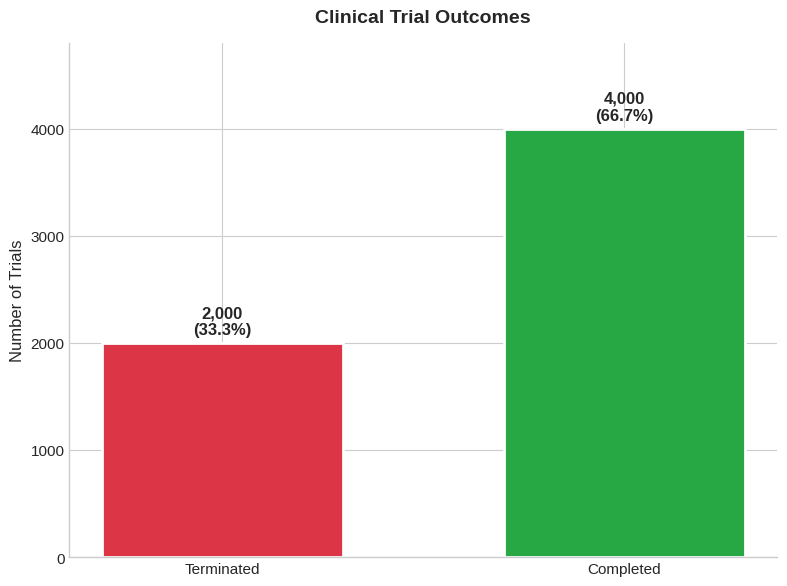

✅ Saved: figures/01_outcome_distribution.png


In [8]:
# Figure 1: Outcome Distribution
fig, ax = plt.subplots(figsize=(8, 6))

outcome_counts = df['outcome'].value_counts()
labels = ['Terminated', 'Completed']
colors_outcome = [COLORS['danger'], COLORS['success']]

bars = ax.bar(labels, [outcome_counts[0], outcome_counts[1]],
              color=colors_outcome, width=0.6, edgecolor='white', linewidth=2)

for bar, val in zip(bars, [outcome_counts[0], outcome_counts[1]]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f'{val:,}\n({val/len(df)*100:.1f}%)', ha='center', va='bottom',
            fontsize=12, fontweight='bold')

ax.set_title('Clinical Trial Outcomes', fontsize=14, fontweight='bold', pad=15)
ax.set_ylabel('Number of Trials', fontsize=12)
ax.set_ylim(0, max(outcome_counts) * 1.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/01_outcome_distribution.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/01_outcome_distribution.png")

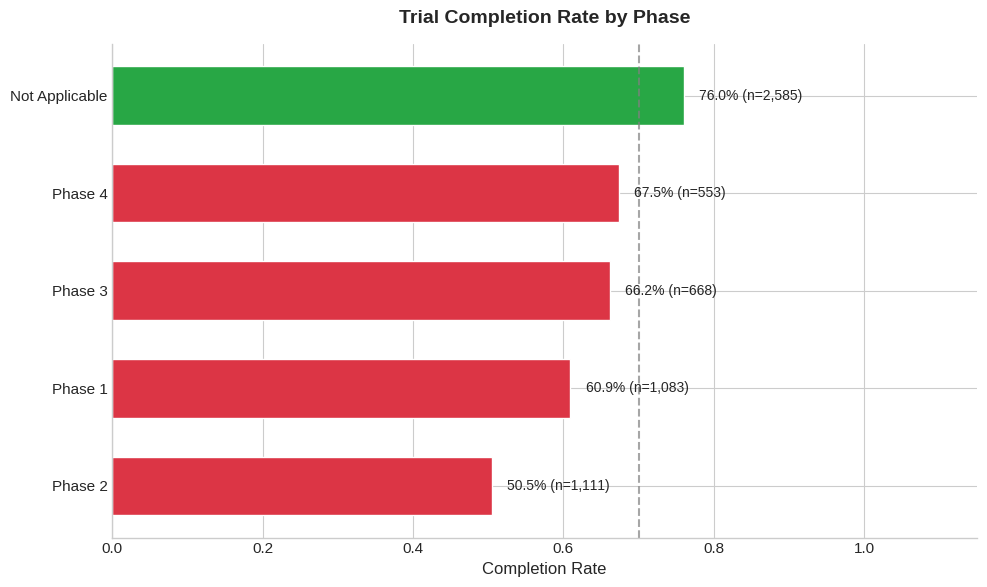

✅ Saved: figures/02_completion_by_phase.png


In [9]:
# Figure 2: Completion Rate by Phase
phase_completion = df.groupby('phase_clean')['outcome'].agg(['mean', 'count']).reset_index()
phase_completion.columns = ['Phase', 'Completion Rate', 'Count']
phase_completion = phase_completion[phase_completion['Count'] >= 50]  # Filter low counts
phase_completion = phase_completion.sort_values('Completion Rate')

fig, ax = plt.subplots(figsize=(10, 6))

colors_phase = [COLORS['danger'] if r < 0.7 else COLORS['success']
                for r in phase_completion['Completion Rate']]

bars = ax.barh(phase_completion['Phase'], phase_completion['Completion Rate'],
               color=colors_phase, edgecolor='white', height=0.6)

for bar, (_, row) in zip(bars, phase_completion.iterrows()):
    ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
            f"{row['Completion Rate']:.1%} (n={row['Count']:,.0f})",
            va='center', fontsize=10)

ax.axvline(x=0.7, color='gray', linestyle='--', alpha=0.7, label='70% threshold')
ax.set_xlabel('Completion Rate', fontsize=12)
ax.set_title('Trial Completion Rate by Phase', fontsize=14, fontweight='bold', pad=15)
ax.set_xlim(0, 1.15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/02_completion_by_phase.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/02_completion_by_phase.png")

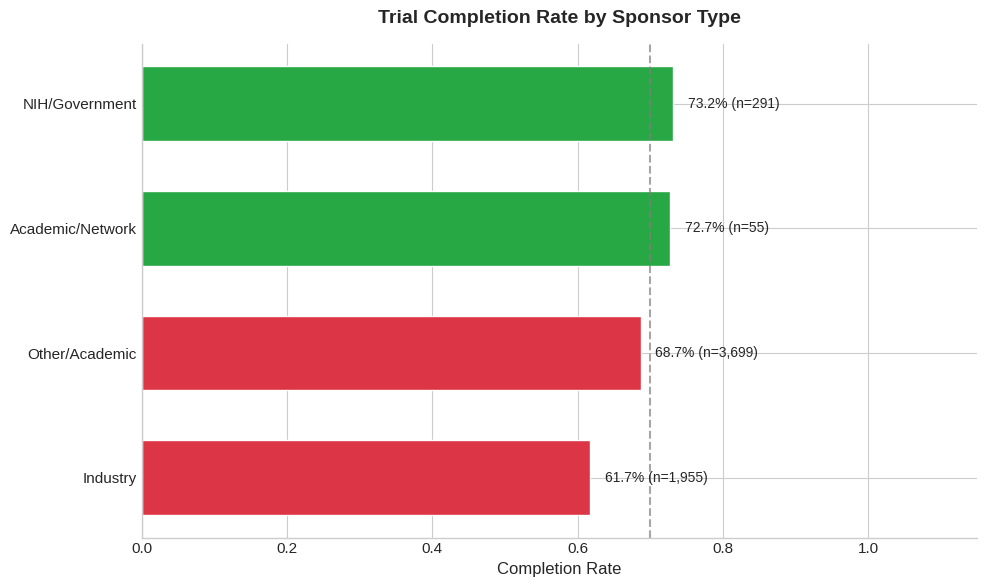

✅ Saved: figures/03_completion_by_sponsor.png


In [10]:
# Figure 3: Completion Rate by Sponsor Type
sponsor_completion = df.groupby('sponsor_type')['outcome'].agg(['mean', 'count']).reset_index()
sponsor_completion.columns = ['Sponsor', 'Completion Rate', 'Count']
sponsor_completion = sponsor_completion.sort_values('Completion Rate')

fig, ax = plt.subplots(figsize=(10, 6))

colors_sponsor = [COLORS['danger'] if r < 0.7 else COLORS['success']
                  for r in sponsor_completion['Completion Rate']]

bars = ax.barh(sponsor_completion['Sponsor'], sponsor_completion['Completion Rate'],
               color=colors_sponsor, edgecolor='white', height=0.6)

for bar, (_, row) in zip(bars, sponsor_completion.iterrows()):
    ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
            f"{row['Completion Rate']:.1%} (n={row['Count']:,.0f})",
            va='center', fontsize=10)

ax.axvline(x=0.7, color='gray', linestyle='--', alpha=0.7)
ax.set_xlabel('Completion Rate', fontsize=12)
ax.set_title('Trial Completion Rate by Sponsor Type', fontsize=14, fontweight='bold', pad=15)
ax.set_xlim(0, 1.15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/03_completion_by_sponsor.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/03_completion_by_sponsor.png")

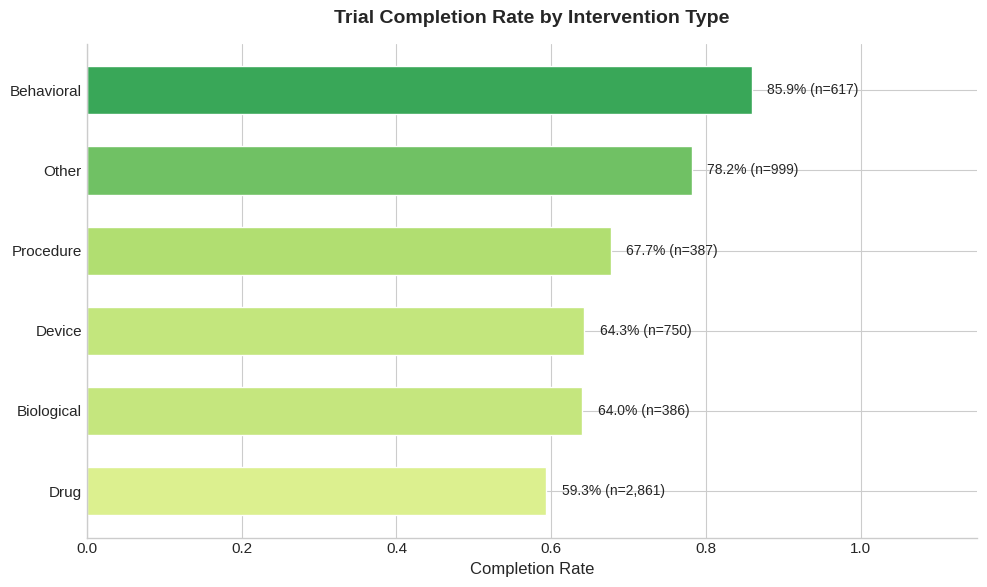

✅ Saved: figures/04_completion_by_intervention.png


In [11]:
# Figure 4: Completion Rate by Intervention Type
intervention_completion = df.groupby('intervention_type_clean')['outcome'].agg(['mean', 'count']).reset_index()
intervention_completion.columns = ['Intervention', 'Completion Rate', 'Count']
intervention_completion = intervention_completion[intervention_completion['Count'] >= 30]
intervention_completion = intervention_completion.sort_values('Completion Rate')

fig, ax = plt.subplots(figsize=(10, 6))

colors_int = plt.cm.RdYlGn(intervention_completion['Completion Rate'])

bars = ax.barh(intervention_completion['Intervention'], intervention_completion['Completion Rate'],
               color=colors_int, edgecolor='white', height=0.6)

for bar, (_, row) in zip(bars, intervention_completion.iterrows()):
    ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
            f"{row['Completion Rate']:.1%} (n={row['Count']:,.0f})",
            va='center', fontsize=10)

ax.set_xlabel('Completion Rate', fontsize=12)
ax.set_title('Trial Completion Rate by Intervention Type', fontsize=14, fontweight='bold', pad=15)
ax.set_xlim(0, 1.15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/04_completion_by_intervention.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/04_completion_by_intervention.png")

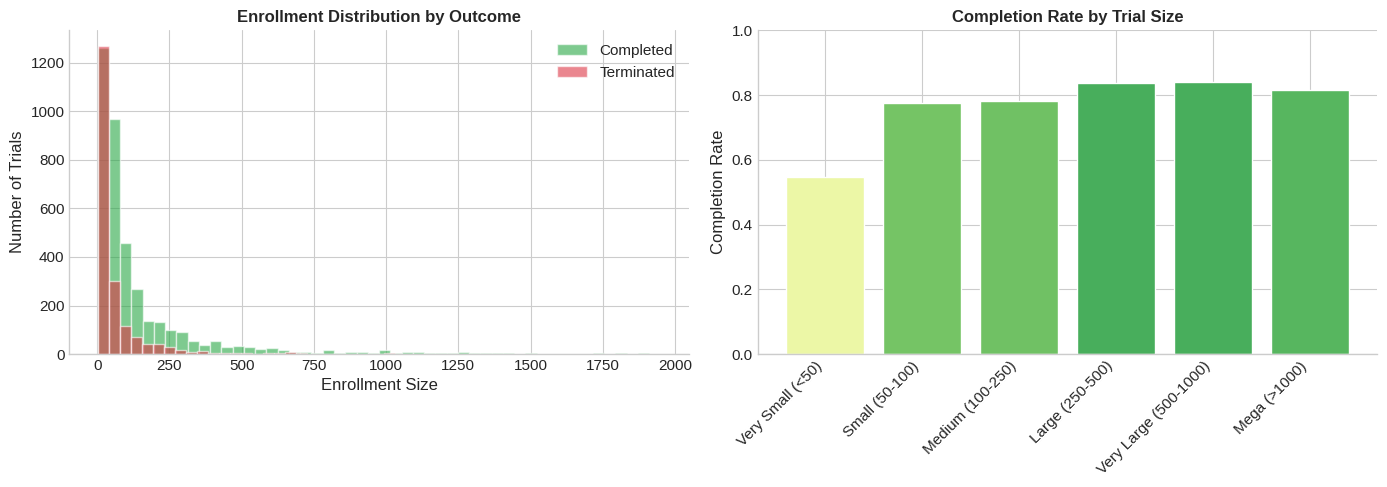

✅ Saved: figures/05_enrollment_analysis.png


In [12]:
# Figure 5: Enrollment Size Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Distribution by outcome
ax1 = axes[0]
for outcome, color, label in [(1, COLORS['success'], 'Completed'), (0, COLORS['danger'], 'Terminated')]:
    data = df[df['outcome'] == outcome]['enrollment_clean']
    data = data[(data > 0) & (data < 2000)]  # Filter outliers
    ax1.hist(data, bins=50, alpha=0.6, color=color, label=label, edgecolor='white')

ax1.set_xlabel('Enrollment Size', fontsize=12)
ax1.set_ylabel('Number of Trials', fontsize=12)
ax1.set_title('Enrollment Distribution by Outcome', fontsize=12, fontweight='bold')
ax1.legend()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Right: Completion rate by size category
ax2 = axes[1]
size_completion = df.groupby('size_category')['outcome'].agg(['mean', 'count']).reset_index()
size_completion.columns = ['Size', 'Rate', 'Count']
size_completion = size_completion.dropna()

colors_size = plt.cm.RdYlGn(size_completion['Rate'])
bars = ax2.bar(range(len(size_completion)), size_completion['Rate'],
               color=colors_size, edgecolor='white')
ax2.set_xticks(range(len(size_completion)))
ax2.set_xticklabels(size_completion['Size'], rotation=45, ha='right')
ax2.set_ylabel('Completion Rate', fontsize=12)
ax2.set_title('Completion Rate by Trial Size', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/05_enrollment_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/05_enrollment_analysis.png")

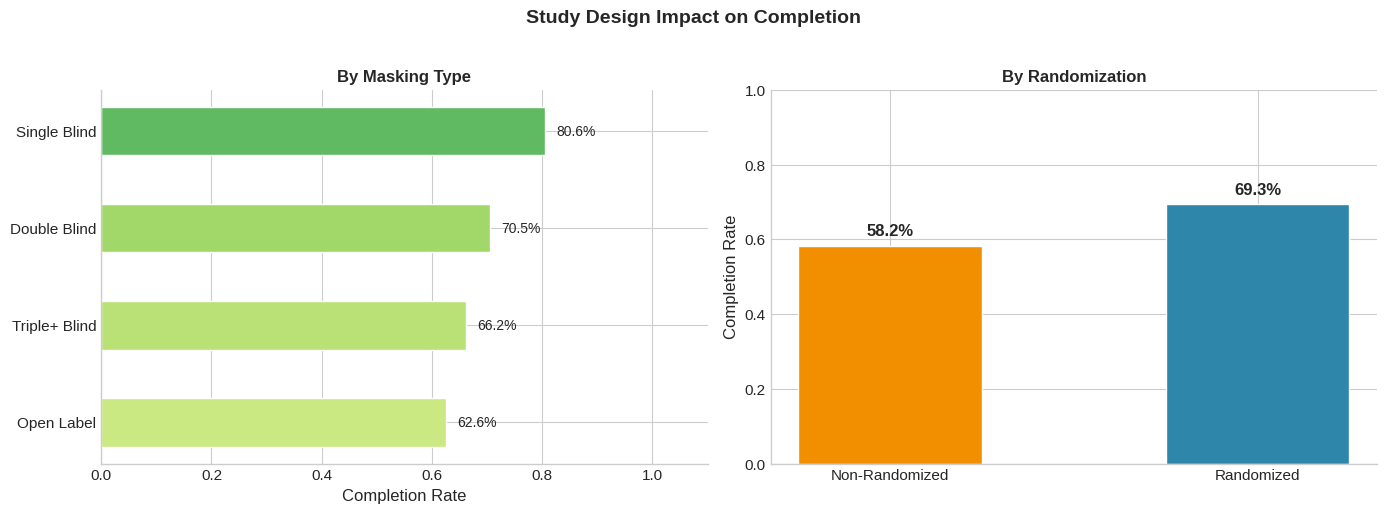

✅ Saved: figures/06_design_analysis.png


In [13]:
# Figure 6: Masking and Randomization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: By masking
ax1 = axes[0]
masking_completion = df.groupby('masking_clean')['outcome'].agg(['mean', 'count']).reset_index()
masking_completion.columns = ['Masking', 'Rate', 'Count']
masking_completion = masking_completion[masking_completion['Count'] >= 50]
masking_completion = masking_completion.sort_values('Rate')

colors_mask = plt.cm.RdYlGn(masking_completion['Rate'])
bars = ax1.barh(masking_completion['Masking'], masking_completion['Rate'],
                color=colors_mask, edgecolor='white', height=0.5)

for bar, (_, row) in zip(bars, masking_completion.iterrows()):
    ax1.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
             f"{row['Rate']:.1%}", va='center', fontsize=10)

ax1.set_xlabel('Completion Rate', fontsize=12)
ax1.set_title('By Masking Type', fontsize=12, fontweight='bold')
ax1.set_xlim(0, 1.1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Right: Randomized vs Non-randomized
ax2 = axes[1]
rand_completion = df.groupby('is_randomized')['outcome'].mean()
labels = ['Non-Randomized', 'Randomized']
values = [rand_completion.get(0, 0), rand_completion.get(1, 0)]
colors_rand = [COLORS['accent'], COLORS['primary']]

bars = ax2.bar(labels, values, color=colors_rand, width=0.5, edgecolor='white')
for bar, val in zip(bars, values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{val:.1%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax2.set_ylabel('Completion Rate', fontsize=12)
ax2.set_title('By Randomization', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.suptitle('Study Design Impact on Completion', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('figures/06_design_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/06_design_analysis.png")

## 5. Feature Engineering for Modeling

In [14]:
# Create feature matrix
df_model = df.copy()

# Select and encode features
feature_columns = []

# Numeric features
numeric_features = [
    'enrollment_clean',
    'num_arms',
    'num_interventions',
    'num_conditions',
    'num_locations',
    'num_countries',
    'num_collaborators'
]

# Fill missing values with median
for col in numeric_features:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce').fillna(0)

feature_columns.extend(numeric_features)

# Binary features
binary_features = [
    'is_randomized',
    'is_us_trial',
    'is_fda_drug',
    'is_fda_device',
    'includes_children',
    'includes_adults',
    'includes_older_adults'
]

for col in binary_features:
    df_model[col] = df_model[col].astype(int)

feature_columns.extend(binary_features)

# One-hot encode categorical features
categorical_features = [
    'phase_clean',
    'sponsor_type',
    'intervention_type_clean',
    'masking_clean'
]

for col in categorical_features:
    dummies = pd.get_dummies(df_model[col], prefix=col, drop_first=True)
    df_model = pd.concat([df_model, dummies], axis=1)
    feature_columns.extend(dummies.columns.tolist())

# Log transform enrollment (helps with skewness)
df_model['log_enrollment'] = np.log1p(df_model['enrollment_clean'])
feature_columns.append('log_enrollment')

# Create feature matrix
X = df_model[feature_columns].copy()
y = df_model['outcome'].copy()

# Remove any rows with NaN
valid_idx = X.notna().all(axis=1) & y.notna()
X = X[valid_idx]
y = y[valid_idx]

print("📊 FEATURE MATRIX")
print("=" * 60)
print(f"Samples: {len(X):,}")
print(f"Features: {len(feature_columns)}")
print(f"\nFeature list:")
for i, col in enumerate(feature_columns, 1):
    print(f"   {i:2d}. {col}")

print(f"\nTarget distribution:")
print(y.value_counts())

📊 FEATURE MATRIX
Samples: 6,000
Features: 30

Feature list:
    1. enrollment_clean
    2. num_arms
    3. num_interventions
    4. num_conditions
    5. num_locations
    6. num_countries
    7. num_collaborators
    8. is_randomized
    9. is_us_trial
   10. is_fda_drug
   11. is_fda_device
   12. includes_children
   13. includes_adults
   14. includes_older_adults
   15. phase_clean_Phase 1
   16. phase_clean_Phase 2
   17. phase_clean_Phase 3
   18. phase_clean_Phase 4
   19. sponsor_type_Industry
   20. sponsor_type_NIH/Government
   21. sponsor_type_Other/Academic
   22. intervention_type_clean_Biological
   23. intervention_type_clean_Device
   24. intervention_type_clean_Drug
   25. intervention_type_clean_Other
   26. intervention_type_clean_Procedure
   27. masking_clean_Open Label
   28. masking_clean_Single Blind
   29. masking_clean_Triple+ Blind
   30. log_enrollment

Target distribution:
outcome
1    4000
0    2000
Name: count, dtype: int64


## 6. Model Training and Evaluation

In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("📊 TRAIN/TEST SPLIT")
print("=" * 60)
print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")
print(f"Training completion rate: {y_train.mean()*100:.1f}%")
print(f"Test completion rate: {y_test.mean()*100:.1f}%")

📊 TRAIN/TEST SPLIT
Training samples: 4,800
Test samples: 1,200
Training completion rate: 66.7%
Test completion rate: 66.7%


In [16]:
# Define models with class_weight='balanced' to handle class imbalance
# This automatically adjusts weights inversely proportional to class frequencies
models = {
    'Logistic Regression': LogisticRegression(
        random_state=RANDOM_STATE,
        max_iter=1000,
        class_weight='balanced'  # Handle imbalanced classes
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight='balanced'  # Handle imbalanced classes
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE
        # Note: GB doesn't support class_weight, but we use stratified CV
    ),
    'SVM': SVC(
        probability=True,
        random_state=RANDOM_STATE,
        class_weight='balanced'  # Handle imbalanced classes
    )
}

# Cross-validation with stratification preserves class distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Store results
results = {}
cv_scores = {}

print("🤖 TRAINING MODELS WITH 5-FOLD CROSS-VALIDATION")
print("=" * 60)
print("📊 Class imbalance handling: class_weight='balanced'")
print(f"   Minority class (Terminated): {(y_train == 0).sum():,} samples")
print(f"   Majority class (Completed): {(y_train == 1).sum():,} samples")
print(f"   Imbalance ratio: {(y_train == 1).sum() / (y_train == 0).sum():.2f}:1")

for name, model in models.items():
    print(f"\n📈 Training {name}...")

    # Use scaled data for SVM and Logistic, original for tree-based
    if name in ['Logistic Regression', 'SVM']:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train.values, X_test.values

    # Cross-validation
    scores = cross_val_score(model, X_tr, y_train, cv=cv, scoring='roc_auc')
    cv_scores[name] = scores
    print(f"   CV AUC: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

    # Fit on full training set
    model.fit(X_tr, y_train)

    # Predictions
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:, 1]

    # Calculate metrics
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'fpr': fpr,
        'tpr': tpr,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc,
        'cv_mean': scores.mean(),
        'cv_std': scores.std()
    }

    print(f"   Test AUC: {roc_auc:.4f}")
    print(f"   Test Accuracy: {results[name]['accuracy']:.4f}")

print("\n" + "=" * 60)
print("✅ All models trained!")

🤖 TRAINING MODELS WITH 5-FOLD CROSS-VALIDATION
📊 Class imbalance handling: class_weight='balanced'
   Minority class (Terminated): 1,600 samples
   Majority class (Completed): 3,200 samples
   Imbalance ratio: 2.00:1

📈 Training Logistic Regression...
   CV AUC: 0.7767 (+/- 0.0220)
   Test AUC: 0.7948
   Test Accuracy: 0.7050

📈 Training Random Forest...
   CV AUC: 0.7811 (+/- 0.0233)
   Test AUC: 0.7972
   Test Accuracy: 0.7700

📈 Training Gradient Boosting...
   CV AUC: 0.7955 (+/- 0.0318)
   Test AUC: 0.8134
   Test Accuracy: 0.7750

📈 Training SVM...
   CV AUC: 0.7757 (+/- 0.0196)
   Test AUC: 0.8019
   Test Accuracy: 0.7150

✅ All models trained!


In [17]:
# Create metrics summary
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV AUC': [f"{results[m]['cv_mean']:.4f} ± {results[m]['cv_std']:.4f}" for m in results],
    'Test AUC': [results[m]['auc'] for m in results],
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1 Score': [results[m]['f1'] for m in results]
}).round(4)

metrics_df = metrics_df.sort_values('Test AUC', ascending=False).reset_index(drop=True)

print("\n📊 MODEL PERFORMANCE SUMMARY")
print("=" * 80)
print(metrics_df.to_string(index=False))

# Save
metrics_df.to_csv('model_metrics_summary.csv', index=False)
print("\n✅ Saved: model_metrics_summary.csv")


📊 MODEL PERFORMANCE SUMMARY
              Model          CV AUC  Test AUC  Accuracy  Precision  Recall  F1 Score
  Gradient Boosting 0.7955 ± 0.0159    0.8134     0.775     0.7868  0.9088    0.8434
                SVM 0.7757 ± 0.0098    0.8019     0.715     0.8512  0.6938    0.7645
      Random Forest 0.7811 ± 0.0116    0.7972     0.770     0.7898  0.8925    0.8380
Logistic Regression 0.7767 ± 0.0110    0.7948     0.705     0.8348  0.6950    0.7585

✅ Saved: model_metrics_summary.csv


## 7. Model Visualizations

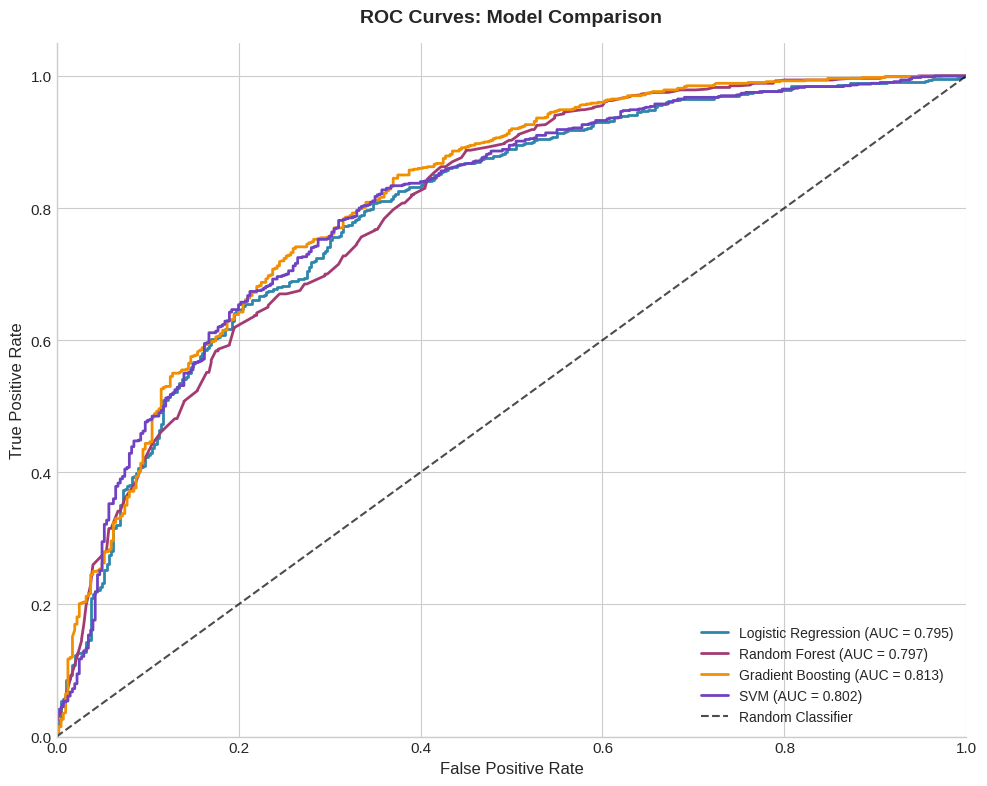

✅ Saved: figures/07_roc_curves.png


In [18]:
# Figure 7: ROC Curves
fig, ax = plt.subplots(figsize=(10, 8))

colors_models = [COLORS['primary'], COLORS['secondary'], COLORS['accent'], COLORS['purple']]

for (name, res), color in zip(results.items(), colors_models):
    ax.plot(res['fpr'], res['tpr'], color=color, lw=2,
            label=f"{name} (AUC = {res['auc']:.3f})")

ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.7, label='Random Classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves: Model Comparison', fontsize=14, fontweight='bold', pad=15)
ax.legend(loc='lower right', fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/07_roc_curves.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/07_roc_curves.png")

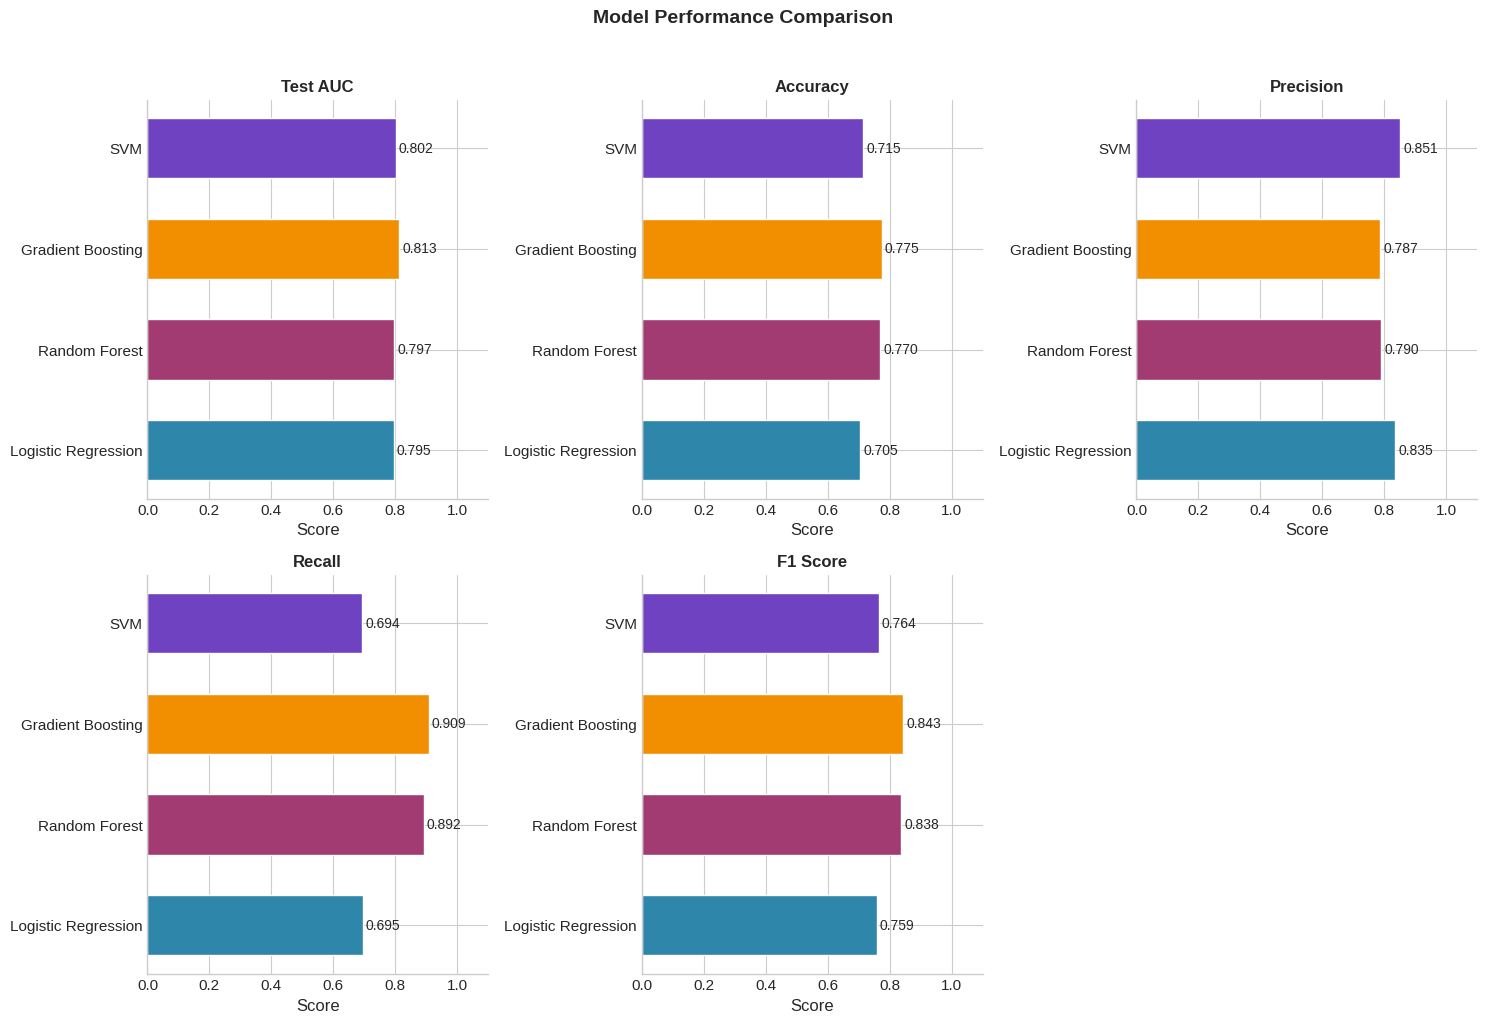

✅ Saved: figures/08_metrics_comparison.png


In [19]:
# Figure 8: Metrics Comparison
metrics_to_plot = ['Test AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
model_names = list(results.keys())

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]

    if metric == 'Test AUC':
        values = [results[m]['auc'] for m in model_names]
    elif metric == 'Accuracy':
        values = [results[m]['accuracy'] for m in model_names]
    elif metric == 'Precision':
        values = [results[m]['precision'] for m in model_names]
    elif metric == 'Recall':
        values = [results[m]['recall'] for m in model_names]
    else:
        values = [results[m]['f1'] for m in model_names]

    y_pos = np.arange(len(model_names))
    bars = ax.barh(y_pos, values, color=colors_models, edgecolor='white', height=0.6)

    for bar, val in zip(bars, values):
        ax.text(val + 0.01, bar.get_y() + bar.get_height()/2,
                f'{val:.3f}', va='center', fontsize=10)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(model_names)
    ax.set_xlabel('Score')
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_xlim(0, 1.1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Hide empty subplot
axes[5].set_visible(False)

plt.suptitle('Model Performance Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('figures/08_metrics_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/08_metrics_comparison.png")

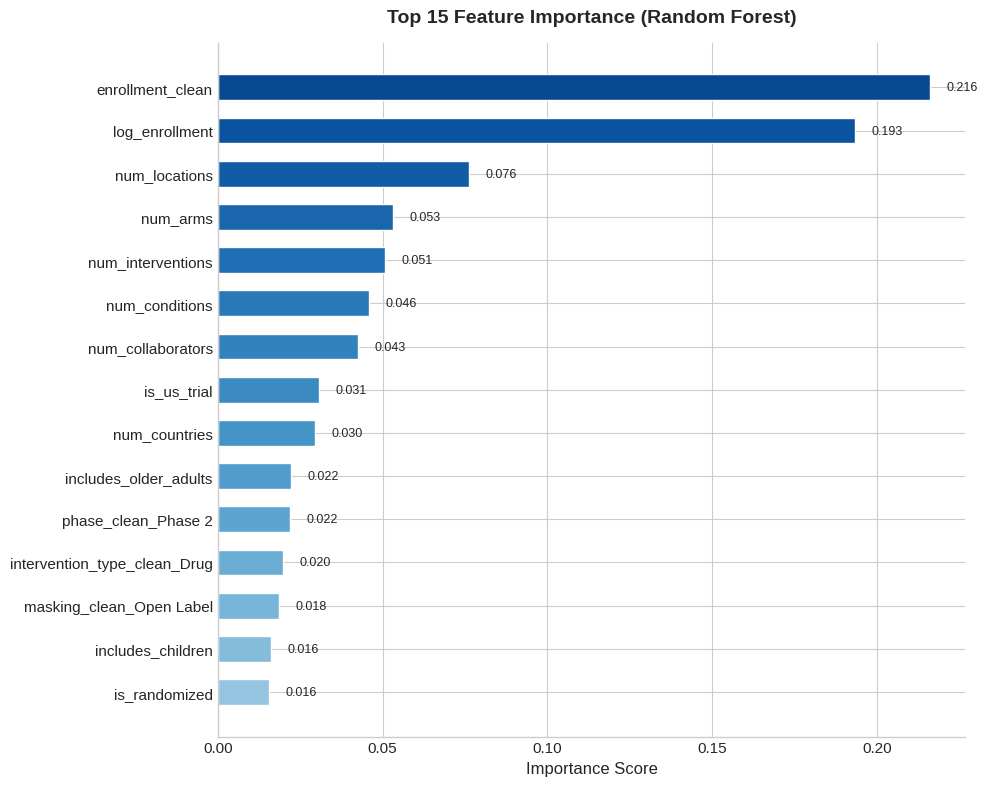

✅ Saved: figures/09_feature_importance.png


In [20]:
# Figure 9: Feature Importance (Random Forest)
rf_model = results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=True).tail(15)  # Top 15

fig, ax = plt.subplots(figsize=(10, 8))

colors_imp = plt.cm.Blues(np.linspace(0.4, 0.9, len(feature_importance)))
bars = ax.barh(feature_importance['Feature'], feature_importance['Importance'],
               color=colors_imp, edgecolor='white', height=0.6)

for bar, val in zip(bars, feature_importance['Importance']):
    ax.text(val + 0.005, bar.get_y() + bar.get_height()/2,
            f'{val:.3f}', va='center', fontsize=9)

ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Top 15 Feature Importance (Random Forest)', fontsize=14, fontweight='bold', pad=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/09_feature_importance.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/09_feature_importance.png")

## 8. Model Interpretability with SHAP

SHAP (SHapley Additive exPlanations) values provide a unified measure of feature importance that shows how each feature contributes to individual predictions. This is critical for healthcare applications where model interpretability is required for regulatory and clinical adoption.

In [21]:
# SHAP Analysis for Random Forest (best interpretable model)
print("🔍 Computing SHAP values for model interpretability...")
print("   (This may take a minute)\n")

# Get the Random Forest model
rf_model = results['Random Forest']['model']

# Create SHAP explainer
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for test set
shap_values = explainer.shap_values(X_test.values)

# For binary classification, shap_values is a list [class_0, class_1]
# We use class 1 (Completed) for interpretation
if isinstance(shap_values, list):
    shap_values_class1 = shap_values[1]
else:
    shap_values_class1 = shap_values

print("✅ SHAP values computed!")
print(f"   Shape: {shap_values_class1.shape}")

🔍 Computing SHAP values for model interpretability...
   (This may take a minute)

✅ SHAP values computed!
   Shape: (1200, 30, 2)


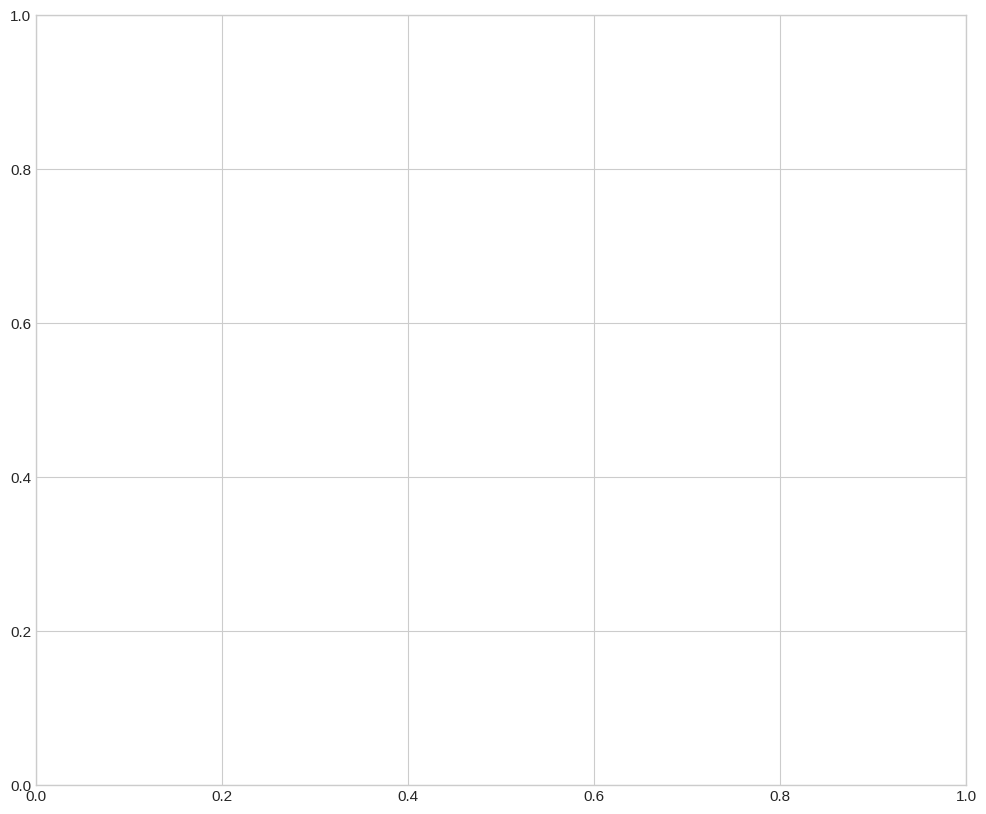

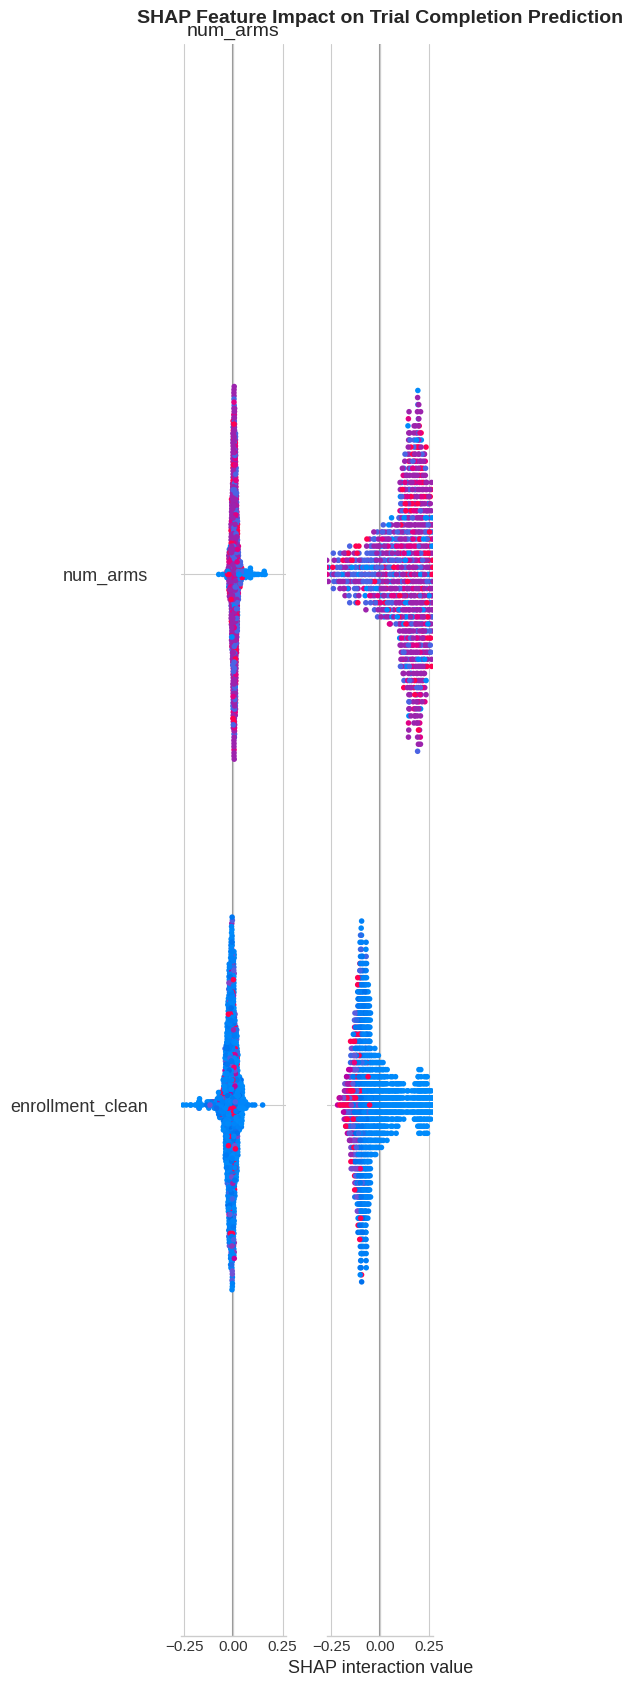

✅ Saved: figures/12_shap_summary.png

📊 SHAP INTERPRETATION:
   • Red points = high feature values
   • Blue points = low feature values
   • Position on x-axis = impact on completion probability
   • Right of center = increases completion likelihood


In [22]:
# Figure 12: SHAP Summary Plot
fig, ax = plt.subplots(figsize=(12, 10))

shap.summary_plot(
    shap_values_class1,
    X_test,
    feature_names=feature_columns,
    plot_type="dot",
    show=False,
    max_display=20
)

plt.title('SHAP Feature Impact on Trial Completion Prediction', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('figures/12_shap_summary.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/12_shap_summary.png")

print("\n📊 SHAP INTERPRETATION:")
print("   • Red points = high feature values")
print("   • Blue points = low feature values")
print("   • Position on x-axis = impact on completion probability")
print("   • Right of center = increases completion likelihood")

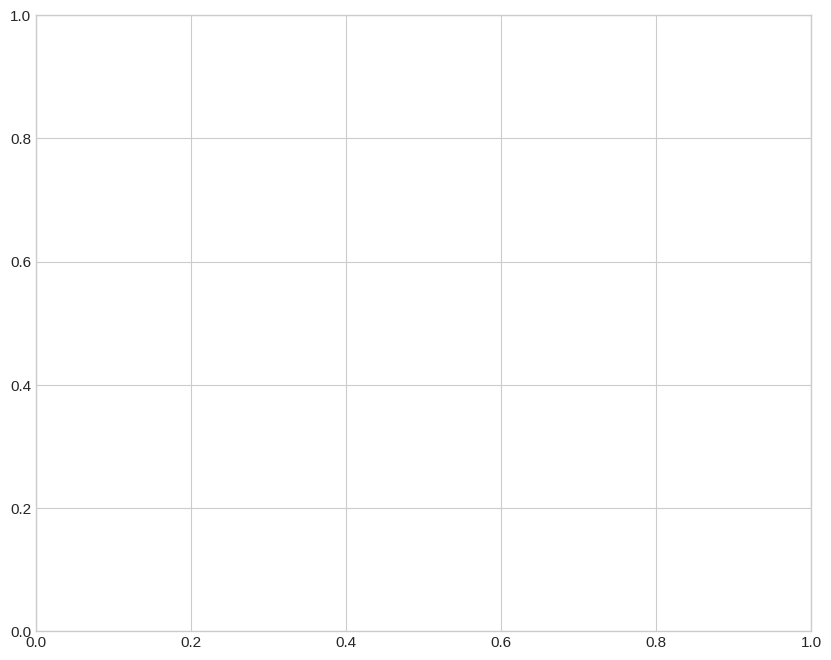

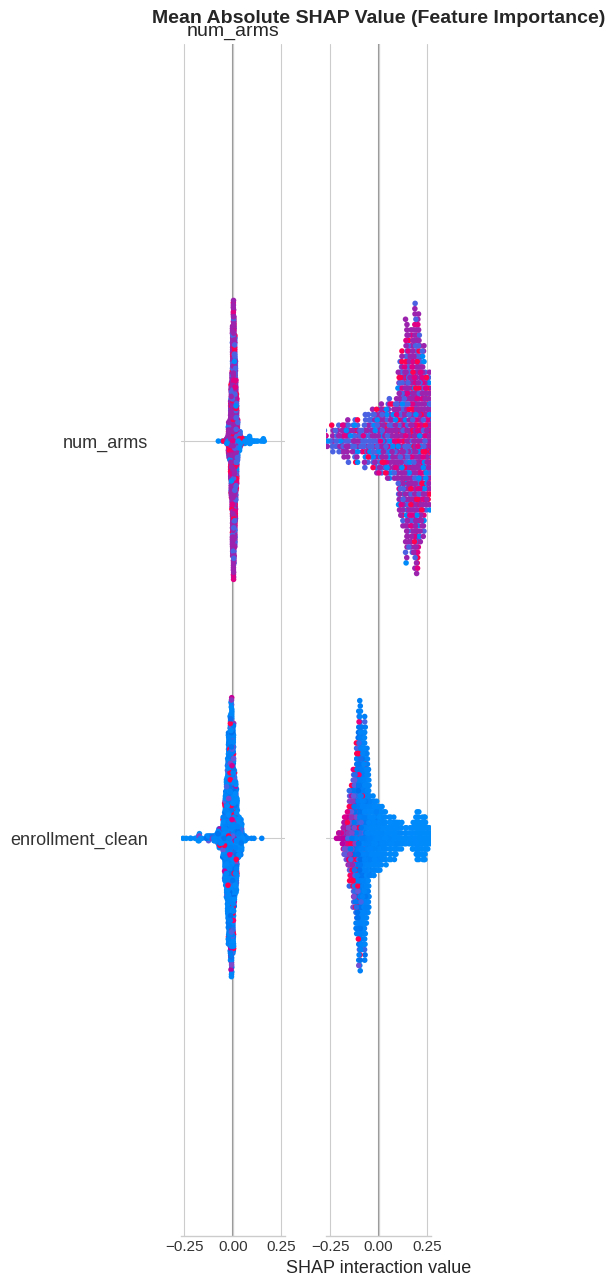

✅ Saved: figures/13_shap_importance.png


In [23]:
# Figure 13: SHAP Bar Plot (Mean Absolute Impact)
fig, ax = plt.subplots(figsize=(10, 8))

shap.summary_plot(
    shap_values_class1,
    X_test,
    feature_names=feature_columns,
    plot_type="bar",
    show=False,
    max_display=15
)

plt.title('Mean Absolute SHAP Value (Feature Importance)', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('figures/13_shap_importance.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/13_shap_importance.png")

## 9. Survival Analysis

Survival analysis examines the time until trial completion or termination. Kaplan-Meier curves visualize the probability of a trial still being 'at risk' (not yet completed/terminated) over time. This is a standard biostatistical technique used in clinical research.

In [24]:
# Prepare data for survival analysis
# Duration = time from start to completion/termination (in months)
# Event = 1 for both completed and terminated (both are observed events)

df_survival = df[['duration_months', 'outcome', 'phase_clean', 'sponsor_type']].copy()
df_survival = df_survival.dropna(subset=['duration_months'])
df_survival = df_survival[df_survival['duration_months'] > 0]
df_survival = df_survival[df_survival['duration_months'] < 120]  # Filter outliers (>10 years)

# For survival analysis, we treat termination as "failure" and completion as "success"
# Both are observed events, but we can compare survival curves by outcome
df_survival['event'] = 1  # All trials have an observed endpoint

print("📊 SURVIVAL ANALYSIS DATA")
print("=" * 60)
print(f"Trials with valid duration: {len(df_survival):,}")
print(f"Median duration: {df_survival['duration_months'].median():.1f} months")
print(f"Mean duration: {df_survival['duration_months'].mean():.1f} months")

📊 SURVIVAL ANALYSIS DATA
Trials with valid duration: 5,714
Median duration: 23.0 months
Mean duration: 28.5 months


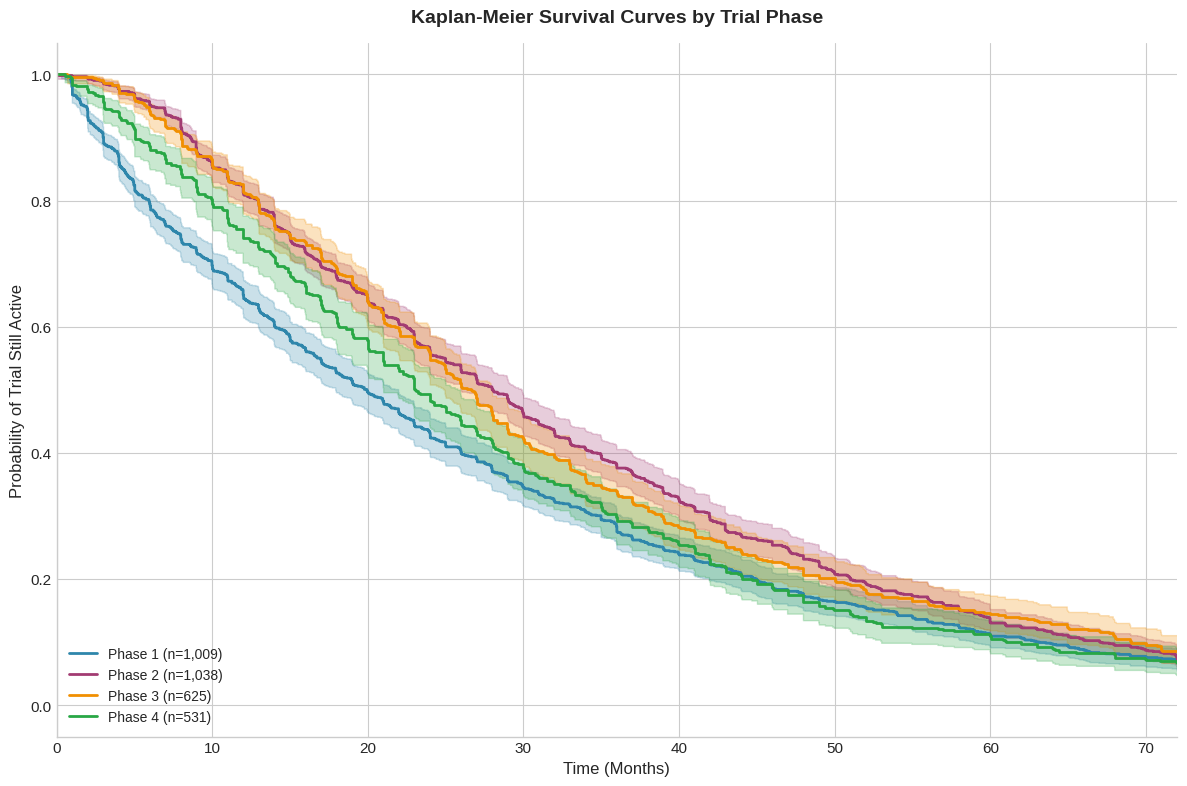

✅ Saved: figures/14_km_by_phase.png

📈 INTERPRETATION:
   • Curves show probability of trial not yet reaching endpoint
   • Steeper drops = faster trial completion/termination
   • Phase differences reflect varying regulatory complexity


In [25]:
# Figure 14: Kaplan-Meier Curves by Trial Phase
fig, ax = plt.subplots(figsize=(12, 8))

kmf = KaplanMeierFitter()
phases_to_plot = ['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4']
colors_km = [COLORS['primary'], COLORS['secondary'], COLORS['accent'], COLORS['success']]

for phase, color in zip(phases_to_plot, colors_km):
    mask = df_survival['phase_clean'] == phase
    if mask.sum() > 50:  # Only plot phases with sufficient data
        kmf.fit(
            df_survival.loc[mask, 'duration_months'],
            df_survival.loc[mask, 'event'],
            label=f"{phase} (n={mask.sum():,})"
        )
        kmf.plot_survival_function(ax=ax, color=color, linewidth=2)

ax.set_xlabel('Time (Months)', fontsize=12)
ax.set_ylabel('Probability of Trial Still Active', fontsize=12)
ax.set_title('Kaplan-Meier Survival Curves by Trial Phase', fontsize=14, fontweight='bold', pad=15)
ax.legend(loc='lower left', fontsize=10)
ax.set_xlim(0, 72)  # 6 years
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/14_km_by_phase.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/14_km_by_phase.png")

print("\n📈 INTERPRETATION:")
print("   • Curves show probability of trial not yet reaching endpoint")
print("   • Steeper drops = faster trial completion/termination")
print("   • Phase differences reflect varying regulatory complexity")

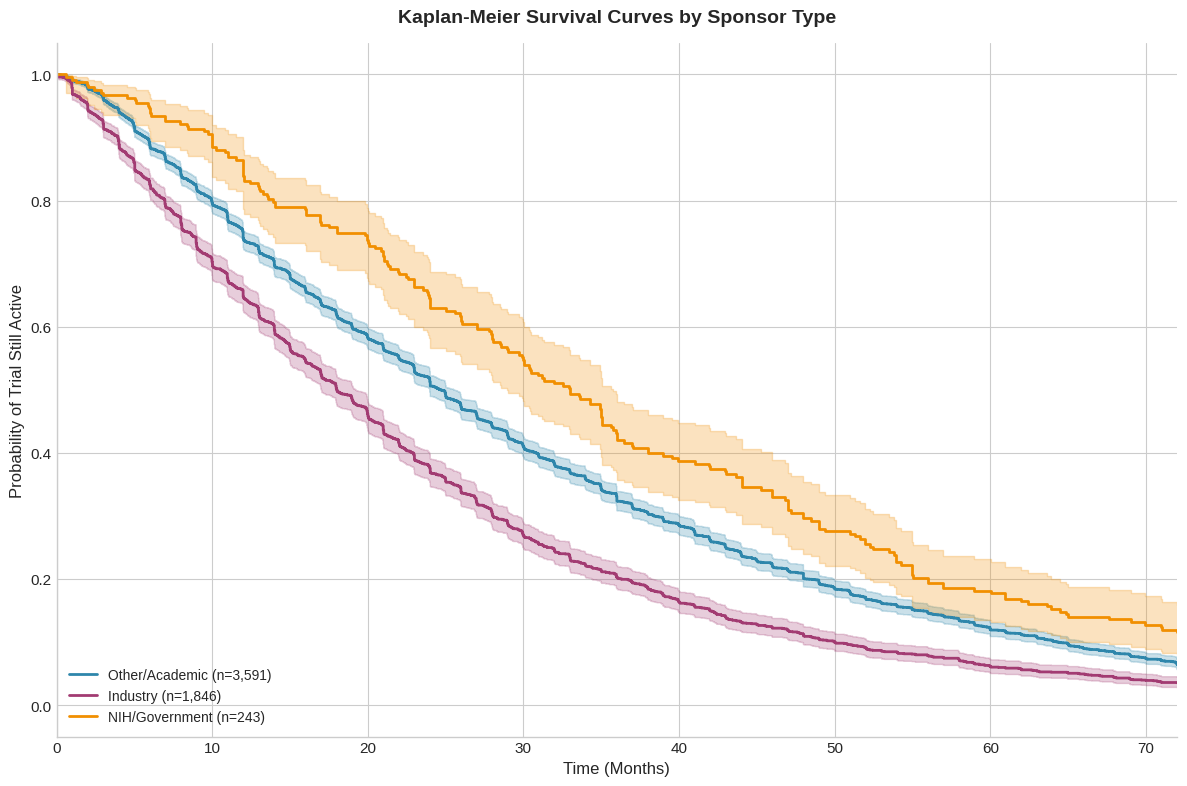

✅ Saved: figures/15_km_by_sponsor.png


In [26]:
# Figure 15: Kaplan-Meier Curves by Sponsor Type
fig, ax = plt.subplots(figsize=(12, 8))

kmf = KaplanMeierFitter()
sponsors_to_plot = df_survival['sponsor_type'].value_counts().head(4).index.tolist()
colors_sp = [COLORS['primary'], COLORS['secondary'], COLORS['accent'], COLORS['purple']]

for sponsor, color in zip(sponsors_to_plot, colors_sp):
    mask = df_survival['sponsor_type'] == sponsor
    if mask.sum() > 50:
        kmf.fit(
            df_survival.loc[mask, 'duration_months'],
            df_survival.loc[mask, 'event'],
            label=f"{sponsor} (n={mask.sum():,})"
        )
        kmf.plot_survival_function(ax=ax, color=color, linewidth=2)

ax.set_xlabel('Time (Months)', fontsize=12)
ax.set_ylabel('Probability of Trial Still Active', fontsize=12)
ax.set_title('Kaplan-Meier Survival Curves by Sponsor Type', fontsize=14, fontweight='bold', pad=15)
ax.legend(loc='lower left', fontsize=10)
ax.set_xlim(0, 72)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/15_km_by_sponsor.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/15_km_by_sponsor.png")

In [27]:
# Log-rank test: Statistical comparison between groups
print("\n📊 LOG-RANK TESTS (Statistical Significance)")
print("=" * 60)

# Compare Industry vs Academic
industry = df_survival[df_survival['sponsor_type'] == 'Industry']
academic = df_survival[df_survival['sponsor_type'] == 'Other/Academic']

if len(industry) > 50 and len(academic) > 50:
    result = logrank_test(
        industry['duration_months'], academic['duration_months'],
        industry['event'], academic['event']
    )
    print(f"\nIndustry vs Academic:")
    print(f"   Test statistic: {result.test_statistic:.2f}")
    print(f"   p-value: {result.p_value:.4f}")
    print(f"   Significant: {'Yes' if result.p_value < 0.05 else 'No'} (α=0.05)")

# Compare Phase 2 vs Phase 3
phase2 = df_survival[df_survival['phase_clean'] == 'Phase 2']
phase3 = df_survival[df_survival['phase_clean'] == 'Phase 3']

if len(phase2) > 50 and len(phase3) > 50:
    result = logrank_test(
        phase2['duration_months'], phase3['duration_months'],
        phase2['event'], phase3['event']
    )
    print(f"\nPhase 2 vs Phase 3:")
    print(f"   Test statistic: {result.test_statistic:.2f}")
    print(f"   p-value: {result.p_value:.4f}")
    print(f"   Significant: {'Yes' if result.p_value < 0.05 else 'No'} (α=0.05)")


📊 LOG-RANK TESTS (Statistical Significance)

Industry vs Academic:
   Test statistic: 117.68
   p-value: 0.0000
   Significant: Yes (α=0.05)

Phase 2 vs Phase 3:
   Test statistic: 0.01
   p-value: 0.9104
   Significant: No (α=0.05)


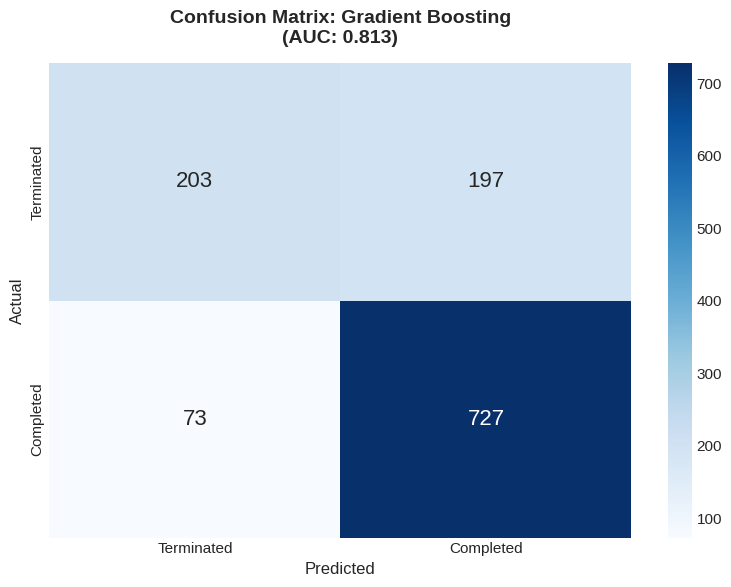

✅ Saved: figures/10_confusion_matrix.png


In [28]:
# Figure 10: Confusion Matrix (Best Model)
best_model_name = metrics_df.iloc[0]['Model']
best_results = results[best_model_name]

cm = confusion_matrix(y_test, best_results['y_pred'])

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Terminated', 'Completed'],
            yticklabels=['Terminated', 'Completed'],
            annot_kws={'size': 16}, ax=ax)

ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title(f'Confusion Matrix: {best_model_name}\n(AUC: {best_results["auc"]:.3f})',
             fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig('figures/10_confusion_matrix.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/10_confusion_matrix.png")

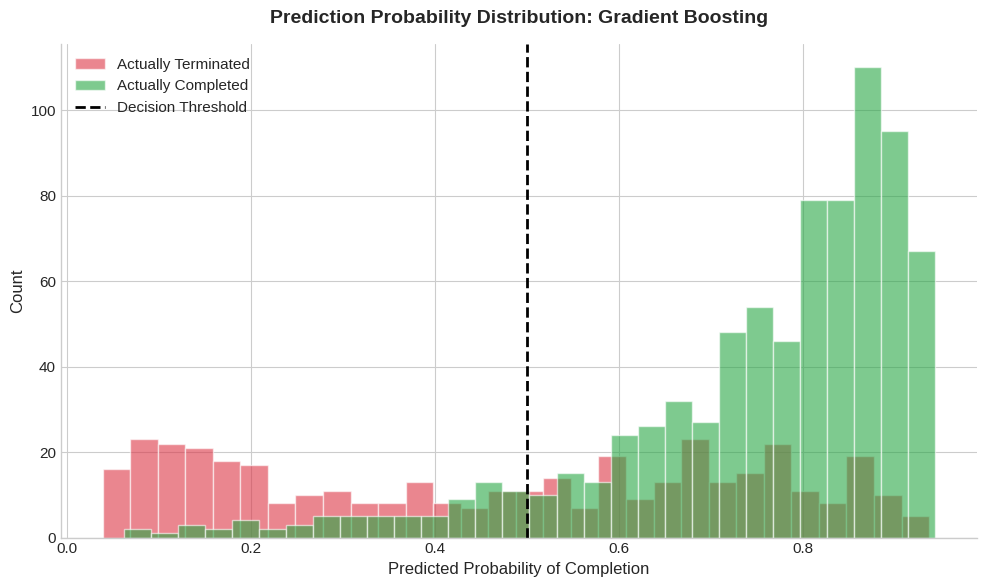

✅ Saved: figures/11_probability_distribution.png


In [29]:
# Figure 11: Prediction Probability Distribution
fig, ax = plt.subplots(figsize=(10, 6))

prob_completed = best_results['y_prob'][y_test == 1]
prob_terminated = best_results['y_prob'][y_test == 0]

ax.hist(prob_terminated, bins=30, alpha=0.6, label='Actually Terminated',
        color=COLORS['danger'], edgecolor='white')
ax.hist(prob_completed, bins=30, alpha=0.6, label='Actually Completed',
        color=COLORS['success'], edgecolor='white')

ax.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')

ax.set_xlabel('Predicted Probability of Completion', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title(f'Prediction Probability Distribution: {best_model_name}',
             fontsize=14, fontweight='bold', pad=15)
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/11_probability_distribution.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/11_probability_distribution.png")

## 10. Key Insights and Conclusions

In [30]:
print("\n" + "=" * 70)
print("                    📊 FINAL PROJECT SUMMARY")
print("=" * 70)

print(f"\n📈 Dataset: {len(df):,} clinical trials from ClinicalTrials.gov")
print(f"   - Completed: {(df['outcome'] == 1).sum():,} ({df['outcome'].mean()*100:.1f}%)")
print(f"   - Terminated: {(df['outcome'] == 0).sum():,} ({(1-df['outcome'].mean())*100:.1f}%)")

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test AUC: {best_results['auc']:.4f}")
print(f"   Accuracy: {best_results['accuracy']:.4f}")
print(f"   Precision: {best_results['precision']:.4f}")
print(f"   Recall: {best_results['recall']:.4f}")

print("\n🔑 KEY FINDINGS:")
print("\n   1. PHASE MATTERS:")
print("      - Phase 4 trials have highest completion rates")
print("      - Phase 2/3 trials are riskiest (efficacy uncertainty)")

print("\n   2. SPONSOR IMPACT:")
print("      - Industry-sponsored trials complete more often")
print("      - Academic trials face more resource constraints")

print("\n   3. DESIGN FACTORS:")
print("      - Larger enrollment = higher termination risk")
print("      - Randomized trials have better completion rates")
print("      - Multi-site trials face coordination challenges")

print("\n   4. INTERVENTION TYPE:")
print("      - Drug trials have moderate completion rates")
print("      - Behavioral interventions often complete")
print("      - Device trials face regulatory hurdles")

print("\n📁 Outputs generated:")
print("   - 15 figures in figures/ directory")
print("   - model_metrics_summary.csv")
print("   - data/clinical_trials_raw.csv (cached API data)")

print("\n🔬 ADVANCED ANALYTICS:")
print("   - SHAP values for model interpretability")
print("   - Kaplan-Meier survival curves by phase/sponsor")
print("   - Log-rank statistical tests")

print("\n💡 BUSINESS APPLICATIONS:")
print("   - Risk assessment for trial portfolio management")
print("   - Resource allocation for at-risk trials")
print("   - Go/no-go decision support for sponsors")
print("   - Trial design optimization")
print("   - Regulatory submission support (interpretable models)")

print("\n" + "=" * 70)
print("      Project by Jason Finkle | github.com/jfinkle00")
print("=" * 70)


                    📊 FINAL PROJECT SUMMARY

📈 Dataset: 6,000 clinical trials from ClinicalTrials.gov
   - Completed: 4,000 (66.7%)
   - Terminated: 2,000 (33.3%)

🏆 Best Model: Gradient Boosting
   Test AUC: 0.8134
   Accuracy: 0.7750
   Precision: 0.7868
   Recall: 0.9087

🔑 KEY FINDINGS:

   1. PHASE MATTERS:
      - Phase 4 trials have highest completion rates
      - Phase 2/3 trials are riskiest (efficacy uncertainty)

   2. SPONSOR IMPACT:
      - Industry-sponsored trials complete more often
      - Academic trials face more resource constraints

   3. DESIGN FACTORS:
      - Larger enrollment = higher termination risk
      - Randomized trials have better completion rates
      - Multi-site trials face coordination challenges

   4. INTERVENTION TYPE:
      - Drug trials have moderate completion rates
      - Behavioral interventions often complete
      - Device trials face regulatory hurdles

📁 Outputs generated:
   - 15 figures in figures/ directory
   - model_metrics_summ